<a href="https://colab.research.google.com/github/cl9612023/Journals-Paper/blob/main/interference%5B_0_5%2C0_5%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, Activation
from keras import optimizers
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import gc
from math import pi
import random

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [ ]:
inpts = []
for l in range(0,4,1):
  ac = str(l+1)
  a = 'inpt'+ac
  inpts.append(a)
print(inpts)
xs = []
for s in range(0,4,1):
  ac = str(s+1)
  a = 'x'+ac
  xs.append(a)
print(xs)

['inpt1', 'inpt2', 'inpt3', 'inpt4']
['x1', 'x2', 'x3', 'x4']


In [ ]:
from keras.layers.normalization import BatchNormalization
from keras.layers import concatenate
from keras.optimizers import SGD
from keras.layers.convolutional import  AveragePooling2D

def Conv2d_BN(x, nb_filter, kernel_size, padding='same', strides=(1, 1)):
    x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, activation='relu')(x)
    return x
def Conv2d_BN2(x, nb_filter, kernel_size, padding='same', strides=(1, 1)):
    x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, activation='relu')(x)
    #x = BatchNormalization(axis=3)(x)   
    return x


def Inception(x, nb_filter):
    branch1x1 = Conv2d_BN2(x, nb_filter, (1, 1), padding='same', strides=(1, 1))

    branch3x3 = Conv2d_BN2(x, nb_filter, (1, 1), padding='same', strides=(1, 1))
    branch3x3 = Conv2d_BN(branch3x3, nb_filter, (1, 3), padding='same', strides=(1, 1))
    branch3x3 = Conv2d_BN2(branch3x3, nb_filter, (3, 1), padding='same', strides=(1, 1))

    branch5x5 = Conv2d_BN2(x, nb_filter, (1, 1), padding='same', strides=(1, 1))
    branch5x5 = Conv2d_BN(branch3x3, nb_filter, (1, 3), padding='same', strides=(1, 1))
    branch5x5 = Conv2d_BN(branch3x3, nb_filter, (3, 1), padding='same', strides=(1, 1))
    branch5x5 = Conv2d_BN(branch3x3, nb_filter, (1, 3), padding='same', strides=(1, 1))
    branch3x3 = Conv2d_BN2(branch3x3, nb_filter, (3, 1), padding='same', strides=(1, 1))

    branchpool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branchpool = Conv2d_BN2(branchpool, nb_filter, (1, 1), padding='same', strides=(1, 1))

    x = concatenate([branch1x1, branch3x3, branch5x5, branchpool], axis=3)

    return x
'''
def build_cnn(width, height,deep, regress=False):
    shape = (width,height,deep)
'''

inpt = Input(shape=(256, 256, 2))    
x = Conv2d_BN(inpt,64, (7, 7),  strides=(2, 2), padding='same')
x  = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x  = Conv2d_BN(x, 192, (3, 3), strides=(1, 1), padding='same')
x  = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x  = Inception(x, 64)  # 256
x  = Inception(x, 120)  # 480
x  = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x  = Inception(x, 128)  # 512
x  = Inception(x, 128)
x  = Inception(x, 128)
x  = Inception(x, 132)  # 528
x  = Inception(x, 208)  # 832
x  = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x  = Inception(x, 208)
x  = Inception(x, 256)  # 1024
x  = AveragePooling2D(pool_size=(7, 7), strides=(7, 7), padding='same')(x)
#x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(32, activation='linear')(x)
model = Model(inpt,x, name='inception')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [ ]:
'''
cnn =build_cnn(224,224,3,regress=False)


cnn.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.sgd(lr=0.01),
              metrics=['accuracy'])
cnn.summary()
'''
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(lr=0.00001), metrics=['accuracy'])

model.summary()

Model: "inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 6336        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 192)  110784      max_pooling2d_1[0][0]            
__________________________________________________________________________________________

In [ ]:
column_names = []
for i in range(0,32,1):
  i = str(i+1)
  a = 'a'+i
  column_names.append(a)
print(column_names)

['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25', 'a26', 'a27', 'a28', 'a29', 'a30', 'a31', 'a32']


In [ ]:
a = np.linspace(-128, 127, 256)
xv,yv = np.meshgrid( a , a )
yv = yv*-1
rho,theta = cart2pol( xv , yv )
m =rho.max()*0.7
rho = rho/m
rho[rho>1]=np.nan
COE = np.zeros([2000,32])
Y = np.zeros((2000, 256, 256,2))

for k in tqdm(range(0,2000,1)):
      c =np.random.rand(1,32)
      c = c.round(6)
      COE[k,:]=c
      phi =c[0,0]*1 \
        +c[0,1]* 2 * rho * np.sin(theta) \
        +c[0,2]* 2 * rho * np.cos(theta)\
        +c[0,3]*np.sqrt(6)*rho**2 * np.sin(2*theta)\
        +c[0,4]*np.sqrt(3)*(2*rho**2 - 1)\
        +c[0,5]*np.sqrt(6)*rho**2 * np.cos(2*theta)\
        +c[0,6]*np.sqrt(8)*rho**3 * np.sin(3*theta)\
        +c[0,7]*np.sqrt(8)*(3*rho**3 - 2*rho) * np.sin(theta)\
        +c[0,8]*np.sqrt(8)*(3*rho**3 - 2*rho) * np.cos(theta)\
        +c[0,9]*np.sqrt(8)*rho**3 * np.cos(3*theta)\
        +c[0,10]*np.sqrt(10)*rho**4* np.sin(4*theta)\
        +c[0,11]*np.sqrt(10)*(4*rho**4 - 3*rho**2) * np.sin(2*theta)\
        +c[0,12]*np.sqrt(5)*(6*rho**4 - 6*rho**2 + 1)\
        +c[0,13]*np.sqrt(10)*(4*rho**4 - 3*rho**2) * np.cos(2*theta)\
        +c[0,14]*np.sqrt(10)*rho**4* np.cos(4*theta)\
        +c[0,15]*np.sqrt(12)*rho**5* np.sin(5*theta)\
        +c[0,16]*np.sqrt(12)*(5*rho**5 - 4*rho**3) * np.sin(3*theta)\
        +c[0,17]*np.sqrt(12)*(10*rho**5 - 12*rho**3 + 3*rho) * np.sin(theta)\
        +c[0,18]*np.sqrt(12)*(10*rho**5 - 12*rho**3 + 3*rho) * np.cos(theta)\
        +c[0,19]*np.sqrt(12)*(5*rho**5 - 4*rho**3) * np.cos(3*theta)\
        +c[0,20]*np.sqrt(12)*rho**5* np.cos(5*theta)\
        +c[0,21]*np.sqrt(14)*rho**6* np.sin(6*theta)\
        +c[0,22]*np.sqrt(14)*(6*rho**6 - 5*rho**4) * np.sin(4*theta)\
        +c[0,23]*np.sqrt(14)*(15*rho**6 - 20*rho**4 + 6*rho**2) * np.sin(2*theta)\
        +c[0,24]*np.sqrt(7)*(20*rho**6 - 30*rho**4 + 12*rho**2 - 1)\
        +c[0,25]*np.sqrt(14)*(15*rho**6 - 20*rho**4 + 6*rho**2) * np.cos(2*theta)\
        +c[0,26]*np.sqrt(14)*(6*rho**6 - 5*rho**4) * np.cos(4*theta)\
        +c[0,27]*np.sqrt(14)*rho**6* np.cos(6*theta)\
        +c[0,28]*4 * rho**7* np.sin(7*theta)\
        +c[0,29]*4 *(7*rho**7 - 6*rho**5) * np.sin(5*theta)\
        +c[0,30]*4 *(21*rho**7 - 30*rho**5 + 10*rho**3) * np.sin(3*theta)\
        +c[0,31]*4 *(35*rho**7 - 60*rho**5 + 30*rho**3 - 4*rho) * np.sin(theta)
      fring = 4 * np.cos(phi*pi/2)**2
      fring2 = 4 * np.cos((phi*pi/2)+(pi/4))**2
      fring3 =fring2 - fring
      fring[np.isnan(fring)] = 0
      fring2[np.isnan(fring2)] = 0
      fring3[np.isnan(fring3)] = 0
      Y[k,:,:,0]=fring
      Y[k,:,:,1]=fring2
      #Y[k,:,:,2]=fring3

raw = pd.DataFrame(COE,columns=column_names)
#Y=Y.reshape(1600, 256, 256,3)
X_test, y_test = Y, raw

In [ ]:
def train_batch_generator():
    a = np.linspace(-128, 127, 256)
    xv,yv = np.meshgrid( a , a )
    yv = yv*-1
    rho,theta = cart2pol( xv , yv )
    m =rho.max()*0.7
    rho = rho/m
    rho[rho>1]=np.nan

    z = np.zeros([6000,32])
    X = np.zeros((6000, 256, 256,2))
    for i in tqdm(range(0,6000,1)):
          c =np.random.rand(1,32)
          z[i,:]=c
          phi =c[0,0]*1 \
          +c[0,1]* 2 * rho * np.sin(theta) \
          +c[0,2]* 2 * rho * np.cos(theta)\
          +c[0,3]*np.sqrt(6)*rho**2 * np.sin(2*theta)\
          +c[0,4]*np.sqrt(3)*(2*rho**2 - 1)\
          +c[0,5]*np.sqrt(6)*rho**2 * np.cos(2*theta)\
          +c[0,6]*np.sqrt(8)*rho**3 * np.sin(3*theta)\
          +c[0,7]*np.sqrt(8)*(3*rho**3 - 2*rho) * np.sin(theta)\
          +c[0,8]*np.sqrt(8)*(3*rho**3 - 2*rho) * np.cos(theta)\
          +c[0,9]*np.sqrt(8)*rho**3 * np.cos(3*theta)\
          +c[0,10]*np.sqrt(10)*rho**4* np.sin(4*theta)\
          +c[0,11]*np.sqrt(10)*(4*rho**4 - 3*rho**2) * np.sin(2*theta)\
          +c[0,12]*np.sqrt(5)*(6*rho**4 - 6*rho**2 + 1)\
          +c[0,13]*np.sqrt(10)*(4*rho**4 - 3*rho**2) * np.cos(2*theta)\
          +c[0,14]*np.sqrt(10)*rho**4* np.cos(4*theta)\
          +c[0,15]*np.sqrt(12)*rho**5* np.sin(5*theta)\
          +c[0,16]*np.sqrt(12)*(5*rho**5 - 4*rho**3) * np.sin(3*theta)\
          +c[0,17]*np.sqrt(12)*(10*rho**5 - 12*rho**3 + 3*rho) * np.sin(theta)\
          +c[0,18]*np.sqrt(12)*(10*rho**5 - 12*rho**3 + 3*rho) * np.cos(theta)\
          +c[0,19]*np.sqrt(12)*(5*rho**5 - 4*rho**3) * np.cos(3*theta)\
          +c[0,20]*np.sqrt(12)*rho**5* np.cos(5*theta)\
          +c[0,21]*np.sqrt(14)*rho**6* np.sin(6*theta)\
          +c[0,22]*np.sqrt(14)*(6*rho**6 - 5*rho**4) * np.sin(4*theta)\
          +c[0,23]*np.sqrt(14)*(15*rho**6 - 20*rho**4 + 6*rho**2) * np.sin(2*theta)\
          +c[0,24]*np.sqrt(7)*(20*rho**6 - 30*rho**4 + 12*rho**2 - 1)\
          +c[0,25]*np.sqrt(14)*(15*rho**6 - 20*rho**4 + 6*rho**2) * np.cos(2*theta)\
          +c[0,26]*np.sqrt(14)*(6*rho**6 - 5*rho**4) * np.cos(4*theta)\
          +c[0,27]*np.sqrt(14)*rho**6* np.cos(6*theta)\
          +c[0,28]*4 * rho**7* np.sin(7*theta)\
          +c[0,29]*4 *(7*rho**7 - 6*rho**5) * np.sin(5*theta)\
          +c[0,30]*4 *(21*rho**7 - 30*rho**5 + 10*rho**3) * np.sin(3*theta)\
          +c[0,31]*4 *(35*rho**7 - 60*rho**5 + 30*rho**3 - 4*rho) * np.sin(theta)
          fring = 4 * np.cos(phi*pi/2)**2
          fring2 = 4 * np.cos((phi*pi/2)+(pi/4))**2
          fring3 = 4 * np.cos((phi*pi/2)-(pi/4))**2
          fring[np.isnan(fring)] = 0
          fring2[np.isnan(fring2)] = 0
          fring3[np.isnan(fring3)] = 0
          X[i,:,:,0] = fring
          X[i,:,:,1] = fring2
          #X[i,:,:,2] = fring3
          
    raw_dataset = pd.DataFrame(z,columns=column_names)
    #X=X.reshape(2500, 256, 256,1)
    X_train, y_train = X , raw_dataset
    del X
    gc.collect()
    yield (X_train, y_train)

In [ ]:
weight_saver = ModelCheckpoint('/content/drive/My Drive/Masterpiece/modle/finalfringe555.h5', monitor='val_loss', save_best_only=True,verbose=2)
earlystop = EarlyStopping(monitor='accuracy', patience=30,verbose=2)
rle = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=20,verbose=1,min_lr=1e-10)
NUM_EPOCHS = 5
history_all = {}
for i in range(NUM_EPOCHS):
    print('################{0} epochs#############'.format(i+1))
    for X_train, y_train in train_batch_generator():
      history = model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs= 100, batch_size=32,verbose=2,callbacks = [weight_saver,earlystop,rle])
      if len(history_all) == 0:
          history_all = {key: [] for key in history.history}
      for key in history_all:
        history_all[key].extend(history.history[key])

################1 epochs#############




Train on 6000 samples, validate on 2000 samples
Epoch 1/100
 - 32s - loss: 0.3325 - accuracy: 0.0308 - val_loss: 0.3312 - val_accuracy: 0.0325

Epoch 00001: val_loss improved from inf to 0.33124, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 2/100
 - 23s - loss: 0.3323 - accuracy: 0.0308 - val_loss: 0.3310 - val_accuracy: 0.0325

Epoch 00002: val_loss improved from 0.33124 to 0.33097, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 3/100
 - 23s - loss: 0.3320 - accuracy: 0.0308 - val_loss: 0.3307 - val_accuracy: 0.0325

Epoch 00003: val_loss improved from 0.33097 to 0.33070, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 4/100
 - 23s - loss: 0.3317 - accuracy: 0.0308 - val_loss: 0.3304 - val_accuracy: 0.0325

Epoch 00004: val_loss improved from 0.33070 to 0.33042, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 5/100
 - 23s - loss: 0.3314 - accura


Train on 6000 samples, validate on 2000 samples
Epoch 1/100
 - 23s - loss: 0.3234 - accuracy: 0.0295 - val_loss: 0.3232 - val_accuracy: 0.0325

Epoch 00001: val_loss improved from 0.32341 to 0.32316, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 2/100
 - 23s - loss: 0.3232 - accuracy: 0.0295 - val_loss: 0.3229 - val_accuracy: 0.0325

Epoch 00002: val_loss improved from 0.32316 to 0.32291, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 3/100
 - 23s - loss: 0.3229 - accuracy: 0.0295 - val_loss: 0.3227 - val_accuracy: 0.0325

Epoch 00003: val_loss improved from 0.32291 to 0.32266, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 4/100
 - 23s - loss: 0.3227 - accuracy: 0.0295 - val_loss: 0.3224 - val_accuracy: 0.0325

Epoch 00004: val_loss improved from 0.32266 to 0.32241, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 5/100
 - 23s - loss: 0.3224 - acc


Train on 6000 samples, validate on 2000 samples
Epoch 1/100
 - 26s - loss: 0.3166 - accuracy: 0.0323 - val_loss: 0.3156 - val_accuracy: 0.0325

Epoch 00001: val_loss improved from 0.31583 to 0.31559, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 2/100
 - 26s - loss: 0.3164 - accuracy: 0.0323 - val_loss: 0.3154 - val_accuracy: 0.0325

Epoch 00002: val_loss improved from 0.31559 to 0.31535, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 3/100
 - 26s - loss: 0.3162 - accuracy: 0.0323 - val_loss: 0.3151 - val_accuracy: 0.0325

Epoch 00003: val_loss improved from 0.31535 to 0.31511, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 4/100
 - 26s - loss: 0.3159 - accuracy: 0.0323 - val_loss: 0.3149 - val_accuracy: 0.0325

Epoch 00004: val_loss improved from 0.31511 to 0.31488, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 5/100
 - 26s - loss: 0.3157 - acc


Train on 6000 samples, validate on 2000 samples
Epoch 1/100
 - 23s - loss: 0.3086 - accuracy: 0.0313 - val_loss: 0.3085 - val_accuracy: 0.0325

Epoch 00001: val_loss improved from 0.30868 to 0.30846, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 2/100
 - 23s - loss: 0.3084 - accuracy: 0.0313 - val_loss: 0.3082 - val_accuracy: 0.0325

Epoch 00002: val_loss improved from 0.30846 to 0.30823, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 3/100
 - 23s - loss: 0.3081 - accuracy: 0.0313 - val_loss: 0.3080 - val_accuracy: 0.0325

Epoch 00003: val_loss improved from 0.30823 to 0.30801, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 4/100
 - 23s - loss: 0.3079 - accuracy: 0.0313 - val_loss: 0.3078 - val_accuracy: 0.0325

Epoch 00004: val_loss improved from 0.30801 to 0.30778, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 5/100
 - 23s - loss: 0.3077 - acc


Train on 6000 samples, validate on 2000 samples
Epoch 1/100
 - 27s - loss: 0.3024 - accuracy: 0.0318 - val_loss: 0.3016 - val_accuracy: 0.0325

Epoch 00001: val_loss improved from 0.30178 to 0.30156, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 2/100
 - 27s - loss: 0.3021 - accuracy: 0.0318 - val_loss: 0.3013 - val_accuracy: 0.0325

Epoch 00002: val_loss improved from 0.30156 to 0.30134, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 3/100
 - 27s - loss: 0.3019 - accuracy: 0.0318 - val_loss: 0.3011 - val_accuracy: 0.0325

Epoch 00003: val_loss improved from 0.30134 to 0.30112, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 4/100
 - 27s - loss: 0.3017 - accuracy: 0.0318 - val_loss: 0.3009 - val_accuracy: 0.0325

Epoch 00004: val_loss improved from 0.30112 to 0.30090, saving model to /content/drive/My Drive/Masterpiece/modle/finalfringe555.h5
Epoch 5/100
 - 27s - loss: 0.3015 - acc

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'test loss: {score[0]}, test acc: {score[1]}')
score

test loss: 0.2949521484375, test acc: 0.03500000014901161


[0.2949521484375, 0.03500000014901161]

In [ ]:
prediction = model.predict(X_test[:2,:])
#print(prediction*max_price)
print(prediction)

[[0.03484122 0.02427562 0.05798432 0.00948934 0.04270577 0.03955653
  0.0382249  0.06207948 0.03103842 0.02548678 0.02052118 0.03763913
  0.04881346 0.05585454 0.05230696 0.0333626  0.04446978 0.04603798
  0.03172866 0.05218029 0.02802722 0.02974085 0.03179936 0.06313521
  0.05101993 0.03760323 0.05776593 0.02493016 0.0291825  0.01051708
  0.05259074 0.05640304]
 [0.0350322  0.02367906 0.05723568 0.01001438 0.042665   0.03837283
  0.03887039 0.06351779 0.03048597 0.02537208 0.01996598 0.03874439
  0.04871723 0.05726494 0.0542247  0.03515656 0.04428423 0.04555932
  0.03239699 0.05184957 0.02853417 0.02907673 0.03119211 0.06256654
  0.0498049  0.03779249 0.05819841 0.02515709 0.02934628 0.01025289
  0.05213194 0.05751901]]


In [ ]:
logs = history_all

Text(0.5, 1.0, 'acc')

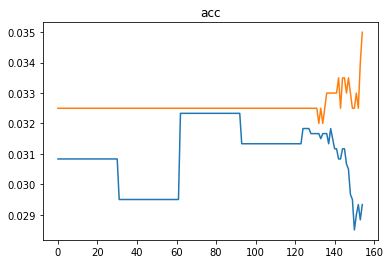

In [ ]:
plt.plot(logs['accuracy'])
plt.plot(logs['val_accuracy'])
plt.title('acc')

Text(0.5, 1.0, 'loss')

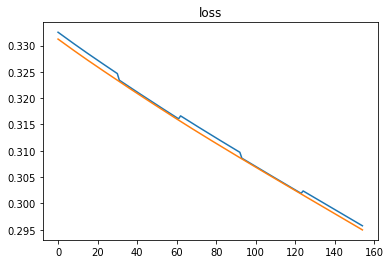

In [ ]:
plt.plot(logs['loss'])
plt.plot(logs['val_loss'])
plt.title('loss')

In [ ]:
predictions = model.predict(X_test)
pre=predictions
ab=y_test
print(pre)
print(ab)
difference = pre - ab
print(difference)

[[0.03484121 0.02427562 0.05798432 ... 0.01051708 0.05259075 0.05640304]
 [0.03503221 0.02367905 0.05723567 ... 0.01025289 0.05213197 0.05751903]
 [0.03493763 0.02411735 0.0585441  ... 0.01018406 0.05254873 0.05725935]
 ...
 [0.03586961 0.02420234 0.05827392 ... 0.0105035  0.05329421 0.05725741]
 [0.03476803 0.02343538 0.05826997 ... 0.01016471 0.05238934 0.05735418]
 [0.03485277 0.02410402 0.05804543 ... 0.00970141 0.05276453 0.05815345]]
            a1        a2        a3  ...       a30       a31       a32
0     0.475549  0.012923  0.611169  ...  0.449145  0.178969  0.018314
1     0.639662  0.331035  0.075817  ...  0.447054  0.443632  0.085431
2     0.029875  0.656629  0.960637  ...  0.927852  0.814229  0.078616
3     0.379891  0.723007  0.719397  ...  0.807333  0.480543  0.035985
4     0.845518  0.523075  0.520298  ...  0.440603  0.960262  0.945113
...        ...       ...       ...  ...       ...       ...       ...
1995  0.636059  0.066408  0.562283  ...  0.019087  0.010800  0.312

In [ ]:
percent_difference = (difference/y_test)*100
abs_percent_difference = np.abs(percent_difference)
mean = np.mean(abs_percent_difference)
std = np.std(abs_percent_difference)
print(mean)
print(std)

a1      98.614294
a2      95.469309
a3     185.281648
a4     113.910816
a5     104.833723
a6     115.175417
a7      97.474157
a8     137.225753
a9     103.571956
a10    177.255493
a11     99.937975
a12    137.134979
a13    105.350584
a14    106.250059
a15    119.404712
a16     93.112663
a17    115.300009
a18    155.178238
a19    110.562909
a20    118.345231
a21     98.595871
a22    113.106077
a23    100.469441
a24     91.671431
a25     96.409036
a26    103.190524
a27     94.457604
a28    224.288776
a29     94.753375
a30     99.853996
a31    107.749976
a32    105.313316
dtype: float64
a1      204.502035
a2       92.571931
a3     3597.868589
a4      616.024596
a5      325.306170
a6      668.895081
a7      144.586162
a8     1335.811821
a9      303.163103
a10    3234.310958
a11     245.203680
a12    1940.400010
a13     388.115415
a14     349.781744
a15     573.352115
a16      86.116420
a17     636.083292
a18    1967.589786
a19     405.808798
a20    1179.527688
a21     248.587889
a22     75